In [1]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from math import sqrt
from pmdarima import auto_arima


In [2]:
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print('Critical Value %s: %.3f' % (key, value))

    if result[1] > 0.05:
        print('Data is not stationary')
    else:
        print('Data is stationary')

In [3]:
df = pd.read_csv('../Data/loreal_stock_price.csv', index_col='Date', parse_dates=True)
df.index = pd.to_datetime(df.index, utc=True).date


In [4]:
scaler = StandardScaler()
# Scaling the data
df["Close"] = scaler.fit_transform(df["Close"].values.reshape(-1, 1))

df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2019-10-29,240.157799,244.117473,237.119004,-1.540000,1172925,0.0,0.0
2019-10-30,243.012451,245.498758,240.986596,-1.558615,758477,0.0,0.0
2019-10-31,241.447007,243.104527,238.868609,-1.578663,301658,0.0,0.0
2019-11-03,239.789455,241.447003,238.224026,-1.577231,432258,0.0,0.0
2019-11-04,239.973657,242.367874,238.960716,-1.538568,461773,0.0,0.0
...,...,...,...,...,...,...,...
2024-10-23,359.750000,364.000000,357.799988,0.270428,360703,0.0,0.0
2024-10-24,358.649994,358.799988,354.649994,0.222999,299447,0.0,0.0
2024-10-27,358.799988,360.899994,356.649994,0.283645,317300,0.0,0.0
2024-10-28,361.450012,362.399994,354.350006,0.222222,307733,0.0,0.0


In [5]:
def reset_date_indx(train_data):
    start_date = train_data.index[0]
    end_date = train_data.index[-1]

    date_range = pd.DataFrame(pd.date_range(start=start_date, end=end_date))
    date_range.columns = ['Date']
    date_range['Date'] = pd.to_datetime(date_range['Date'])
    series_df = train_data.to_frame().reset_index().rename(columns={'index': 'Date'})
    series_df['Date'] = pd.to_datetime(series_df['Date'])

    merged_df = pd.merge(date_range, series_df, on='Date', how='left')
    merged_df.set_index('Date', inplace=True)
    merged_df.fillna(method='ffill', inplace=True)
    return merged_df


In [6]:
df = reset_date_indx(df['Close'])
df

C:\Users\lamma\AppData\Local\Temp\ipykernel_31712\117374445.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='ffill', inplace=True)


,Close
Date,
2019-10-29,-1.540000
2019-10-30,-1.558615
2019-10-31,-1.578663
2019-11-01,-1.578663
2019-11-02,-1.578663
...,...
2024-10-25,0.222999
2024-10-26,0.222999
2024-10-27,0.283645


In [7]:
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

In [8]:
test_stationarity(train_data) # Train data is stationary

ADF Statistic: -1.355082
p-value: 0.603611
Critical Value 1%: -3.435
Critical Value 5%: -2.864
Critical Value 10%: -2.568
Data is not stationary


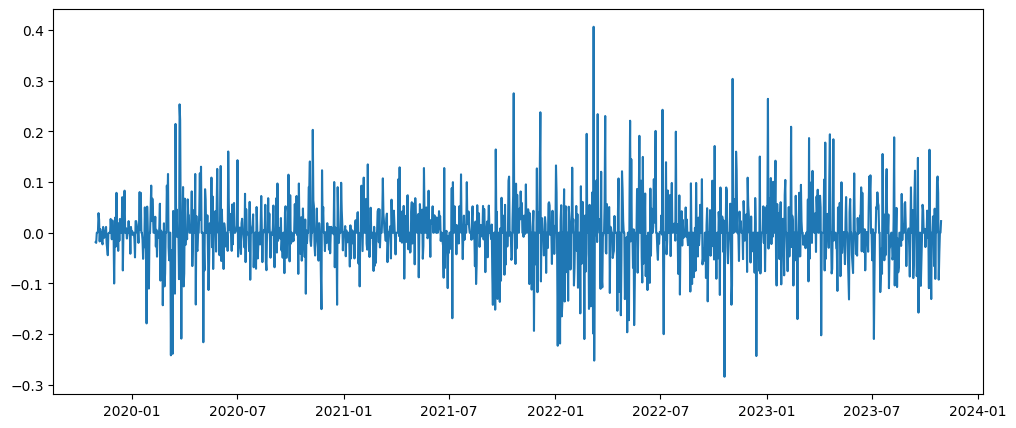

In [9]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))
diff = train_data.diff().dropna()
plt.plot(diff, label='Close_diff')
plt.show()

In [10]:
test_stationarity(diff)

ADF Statistic: -18.966293
p-value: 0.000000
Critical Value 1%: -3.435
Critical Value 5%: -2.864
Critical Value 10%: -2.568
Data is stationary


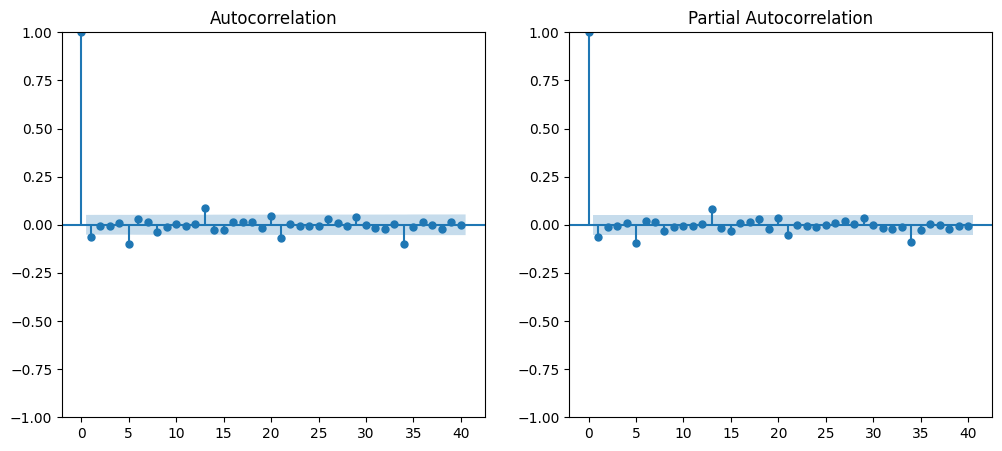

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sm.graphics.tsa.plot_acf(diff, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff, lags=40, ax=ax[1])
plt.show()

In [12]:
ARIMA_model = ARIMA(train_data, order=(5, 1, 5), freq='D')
ARIMA_model_fit = ARIMA_model.fit()
print(ARIMA_model_fit.summary())

C:\Users\lamma\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1462
Model:                 ARIMA(5, 1, 5)   Log Likelihood                1954.023
Date:                Thu, 14 Nov 2024   AIC                          -3886.045
Time:                        13:17:22   BIC                          -3827.890
Sample:                    10-29-2019   HQIC                         -3864.352
                         - 10-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0789      0.476     -0.166      0.868      -1.012       0.854
ar.L2          0.0279      0.379      0.074      0.941      -0.714       0.770
ar.L3          0.4775      0.210      2.271      0.0

C:\Users\lamma\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


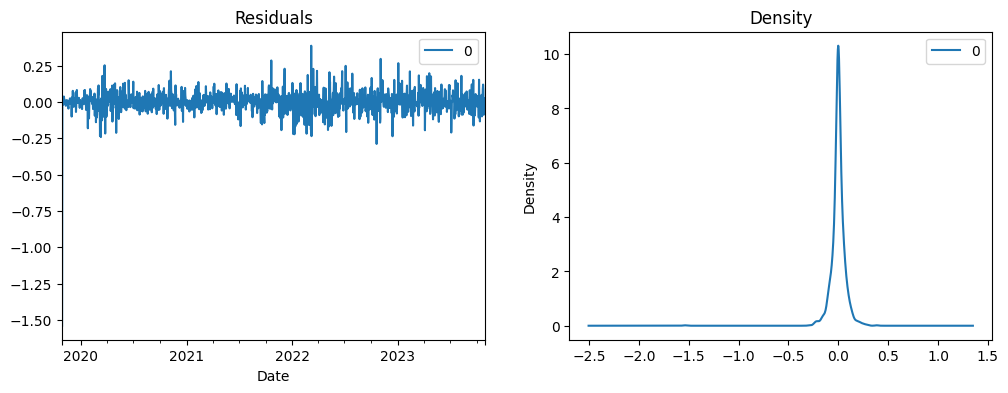

In [13]:
# Plot residual errors
residuals = pd.DataFrame(ARIMA_model_fit.resid)

fig, ax = plt.subplots(1,2, figsize=(12,4))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [14]:
start_predict_date = len(train_data)
end_predict_date = start_predict_date + len(test_data) - 1
predictions = ARIMA_model_fit.predict(start=0, end=end_predict_date, typ='levels')


C:\Users\lamma\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [15]:
df["Close"] = scaler.inverse_transform(df["Close"].values.reshape(-1, 1))
predictions = scaler.inverse_transform(predictions.values.reshape(-1, 1))
predictions

array([[341.30944565],
       [242.27577212],
       [241.15365993],
       ...,
       [386.08254424],
       [386.08254417],
       [386.08254425]])

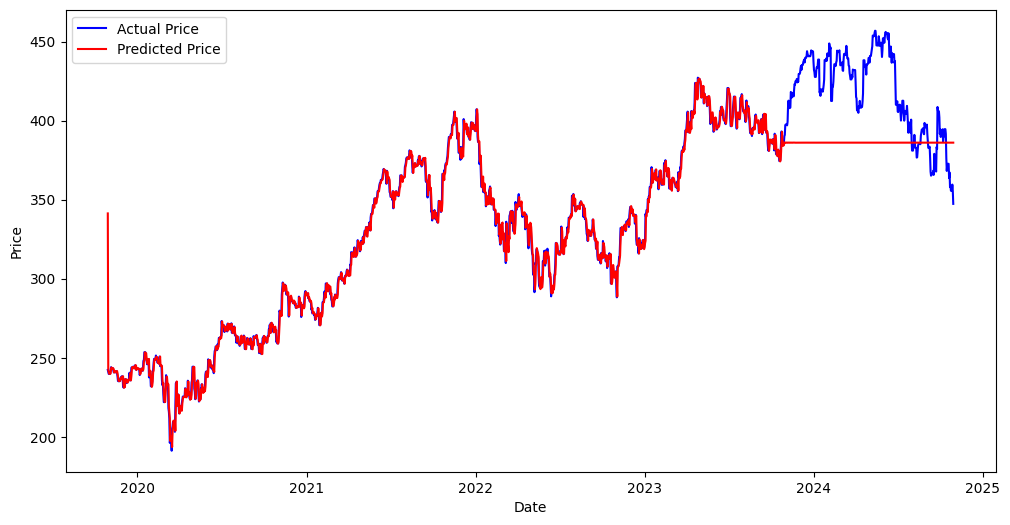

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Close"], color='blue', label='Actual Price')
plt.plot(df.index, predictions, color='red', label='Predicted Price')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [17]:
mse = mean_squared_error(df, predictions)
mae = mean_absolute_error(df, predictions)
mrse = sqrt(mse)
r2 = r2_score(df, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Root Squared Error: {mrse}')
print(f'R2 Score: {r2}')

Mean Squared Error: 354.7992654764167
Mean Absolute Error: 9.286745911007895
Mean Root Squared Error: 18.836115987018573
R2 Score: 0.9151120029442606
